# Churn Prediction with PySpark

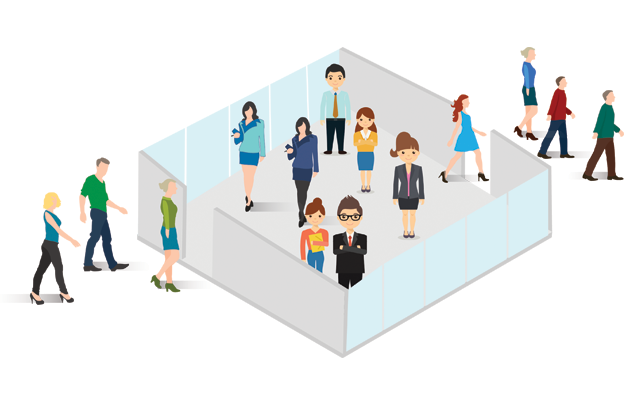

## Objective 

**Can you develop a model of machine learning that can predict customers who will leave the company?**

The aim is to estimate whether a bank's customers leave the bank or not. The event that defines the customer abandonment is the closing of the customer's bank account.

## Details about the dataset:
It consists of 10000 observations and 12 variables. Independent variables contain information about customers. Dependent variable refers to customer abandonment status.

### **Variables:**

**RowNumber** — corresponds to the record (row) number and has no effect on the output. This column will be removed.

**CustomerId** — contains random values and has no effect on customer leaving the bank. This column will be removed.

**Surname** — the surname of a customer has no impact on their decision to leave the bank. This column will be removed.

**CreditScore** — can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.

**Geography** — a customer’s location can affect their decision to leave the bank. We’ll keep this column.

**Gender** — it’s interesting to explore whether gender plays a role in a customer leaving the bank. We’ll include this column, too.

**Age** — this is certainly relevant, since older customers are less likely to leave their bank than younger ones.

**Tenure** — refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.

**Balance** — also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.

**NumOfProducts** — refers to the number of products that a customer has purchased through the bank.

**HasCrCard** — denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank. (0=No,1=Yes)

**IsActiveMember** — active customers are less likely to leave the bank, so we’ll keep this. (0=No,1=Yes)

**EstimatedSalary** — as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

**Exited** — whether or not the customer left the bank. This is what we have to predict. (0=No,1=Yes)

# 1) Installation Operations

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

import findspark

findspark.init("C:\spark")

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [2]:
spark = SparkSession.builder \
        .master("local") \
        .appName("pyspark_odev")\
        .getOrCreate()

In [3]:
sc = spark.sparkContext
sc

<SparkContext master=local appName=pyspark_odev>

# 2) Data Understanding

In [26]:
spark_df = spark.read.csv("churn.csv", header = True, inferSchema = True)

In [27]:
spark_df.show(10)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

In [28]:
spark_df.count()

10000

In [29]:
spark_df.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
RowNumber,10000,5000.5,2886.8956799071675,1,10000
CustomerId,10000,1.56909405694E7,71936.18612274907,15565701,15815690
Surname,10000,None,None,Abazu,Zuyeva
CreditScore,10000,650.5288,96.65329873613035,350,850
Geography,10000,None,None,France,Spain
Gender,10000,None,None,Female,Male
Age,10000,38.9218,10.487806451704587,18,92
Tenure,10000,5.0128,2.8921743770496837,0,10
Balance,10000,76485.88928799961,62397.40520238599,0.0,250898.09


In [30]:
spark_df = spark_df.withColumnRenamed("RowNumber", "index")

In [31]:
spark_df.show(5)

+-----+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|index|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+-----+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|    1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|    2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|    3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|    4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|
|    5|  15737888|Mi

# 3) Selecting The Dependent Variable

In [32]:
from pyspark.ml.feature import StringIndexer
stringIndexer=StringIndexer(inputCol ="Exited", outputCol = "label")

In [33]:
mod = stringIndexer.fit(spark_df)
indexed = mod.transform(spark_df)

spark_df = indexed.withColumn("label", indexed["label"].cast("integer"))

In [34]:
spark_df.toPandas().head()

,index,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,label
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0


In [35]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
spark_df = spark_df.drop("CustomerId", "Surname", "index")
spark_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,label
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0


# 4) StringIndexer Operation

In [36]:
# Categorical variables were converted with StringIndexer.
geo_indexer = StringIndexer(inputCol = "Geography", outputCol = "Geo_cat") 
geo_indexer_model = geo_indexer.fit(spark_df)
geo_indexer_df = geo_indexer_model.transform(spark_df)
geo_indexer_df.toPandas().head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,label,Geo_cat
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0.0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,2.0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0.0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0.0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,2.0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,1,2.0
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0,0,0.0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,1,1.0
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,0,0.0
9,684,France,Male,27,2,134603.88,1,1,1,71725.73,0,0,0.0


In [37]:
# Categorical variables were converted with StringIndexer.
gender_indexer = StringIndexer(inputCol = "Gender", outputCol = "Gender_cat")
gender_indexer_model = gender_indexer.fit(geo_indexer_df)
gender_indexer_df = gender_indexer_model.transform(geo_indexer_df)
gender_indexer_df.toPandas().head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,label,Geo_cat,Gender_cat
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0.0,1.0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,2.0,1.0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0.0,1.0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0.0,1.0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,2.0,1.0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,1,2.0,0.0
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0,0,0.0,0.0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,1,1.0,1.0
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,0,0.0,0.0
9,684,France,Male,27,2,134603.88,1,1,1,71725.73,0,0,0.0,0.0


# 5) One Hot Encoder

After StringIndexer process, one hot encoding is performed on the pyspark side. These two operations are performed in a row. 

References: https://www.udemy.com/course/apache-spark-egitimi/

In [38]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol = "Geo_cat", outputCol = "Geo_ohe")
encoder_df = encoder.transform(gender_indexer_df)
encoder_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,label,Geo_cat,Gender_cat,Geo_ohe
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0.0,1.0,"(1.0, 0.0)"
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,2.0,1.0,"(0.0, 0.0)"
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0.0,1.0,"(1.0, 0.0)"
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0.0,1.0,"(1.0, 0.0)"
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,2.0,1.0,"(0.0, 0.0)"


In [39]:
encoder = OneHotEncoder(inputCol = "Gender_cat", outputCol = "Gender_ohe")
encoder_df = encoder.transform(encoder_df)
encoder_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,label,Geo_cat,Gender_cat,Geo_ohe,Gender_ohe
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0.0,1.0,"(1.0, 0.0)",(0.0)
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,2.0,1.0,"(0.0, 0.0)",(0.0)
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0.0,1.0,"(1.0, 0.0)",(0.0)
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0.0,1.0,"(1.0, 0.0)",(0.0)
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,2.0,1.0,"(0.0, 0.0)",(0.0)


# 6) Vector Assembler

Variables are taken under a single vector roof. Features and label values are given to the model on the PySpark side. For this reason, variables are collected as a vector structure under features.

In [40]:
from pyspark.ml.feature import VectorAssembler
cols = ["CreditScore","Age", "Tenure", "Balance","NumOfProducts", "HasCrCard","IsActiveMember","EstimatedSalary", "Geo_ohe", "Gender_ohe"]
va = VectorAssembler(inputCols = cols, outputCol = "features")
va_df = va.transform(encoder_df)
va_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,label,Geo_cat,Gender_cat,Geo_ohe,Gender_ohe,features
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0.0,1.0,"(1.0, 0.0)",(0.0),"[619.0, 42.0, 2.0, 0.0, 1.0, 1.0, 1.0, 101348...."
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,2.0,1.0,"(0.0, 0.0)",(0.0),"[608.0, 41.0, 1.0, 83807.86, 1.0, 0.0, 1.0, 11..."
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0.0,1.0,"(1.0, 0.0)",(0.0),"[502.0, 42.0, 8.0, 159660.8, 3.0, 1.0, 0.0, 11..."
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0.0,1.0,"(1.0, 0.0)",(0.0),"(699.0, 39.0, 1.0, 0.0, 2.0, 0.0, 0.0, 93826.6..."
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,2.0,1.0,"(0.0, 0.0)",(0.0),"[850.0, 43.0, 2.0, 125510.82, 1.0, 1.0, 1.0, 7..."


# 7) Scaling

In [41]:
from pyspark.ml.feature import  StandardScaler, Normalizer
#Initialize the standardScaler
standardScaler = StandardScaler(inputCol = "features", outputCol = "features_scaled")
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(va_df).transform(va_df)
scaled_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,label,Geo_cat,Gender_cat,Geo_ohe,Gender_ohe,features,features_scaled
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0.0,1.0,"(1.0, 0.0)",(0.0),"[619.0, 42.0, 2.0, 0.0, 1.0, 1.0, 1.0, 101348....","[6.404333924389993, 4.0046505619078925, 0.6915..."
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,2.0,1.0,"(0.0, 0.0)",(0.0),"[608.0, 41.0, 1.0, 83807.86, 1.0, 0.0, 1.0, 11...","[6.2905250824379895, 3.9093017390053237, 0.345..."
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0.0,1.0,"(1.0, 0.0)",(0.0),"[502.0, 42.0, 8.0, 159660.8, 3.0, 1.0, 0.0, 11...","[5.193821696355051, 4.0046505619078925, 2.7660..."
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0.0,1.0,"(1.0, 0.0)",(0.0),"(699.0, 39.0, 1.0, 0.0, 2.0, 0.0, 0.0, 93826.6...","(7.232034593131834, 3.718604093200186, 0.34576..."
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,2.0,1.0,"(0.0, 0.0)",(0.0),"[850.0, 43.0, 2.0, 125510.82, 1.0, 1.0, 1.0, 7...","[8.794319605382057, 4.099999384810461, 0.69152..."


In [42]:
final_df = scaled_df.select(["features_scaled","label"])

In [43]:
final_df = final_df.withColumnRenamed("features_scaled", "features")
final_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[6.40433392438999...|    1|
|[6.29052508243798...|    0|
|[5.19382169635505...|    1|
|(11,[0,1,2,4,7,8]...|    0|
|[8.79431960538205...|    0|
|[6.67333664173109...|    1|
|[8.50462437132241...|    0|
|[3.89019314308665...|    1|
|[5.18347543799577...|    0|
|[7.07684071774273...|    0|
|[5.46282441369614...|    0|
|[5.14209040455868...|    0|
|[4.92481897901395...|    0|
|(11,[0,1,2,4,7,8]...|    0|
|[6.56987405813836...|    0|
|[6.37329514931217...|    0|
|[6.75610670860527...|    1|
|[5.68009583924088...|    0|
|(11,[0,1,2,4,7,10...|    0|
|[7.51138356883220...|    0|
+--------------------+-----+
only showing top 20 rows



# 7) Train-Test Separation

- Train Data Set = % 70
- Test Data Set % 30

In [44]:
splits = final_df.randomSplit([0.70, 0.30])
train_df = splits[0]
test_df = splits[1]

# 8) Model Installation

In [45]:
from pyspark.ml.classification import GBTClassifier
gbm = GBTClassifier(maxIter = 10, featuresCol = "features", labelCol = "label")
gbm_model = gbm.fit(train_df)
y_pred = gbm_model.transform(test_df)
y_pred.toPandas().head()

,features,label,rawPrediction,probability,prediction
0,"(3.9626169516015626, 4.576743499323306, 2.7660...",1,"[-0.04040592287569879, 0.04040592287569879]","[0.4798080260983185, 0.5201919739016815]",1.0
1,"(5.390400605181238, 4.672092322225875, 1.38304...",1,"[0.5764836827288743, -0.5764836827288743]","[0.7600525009170728, 0.23994749908292723]",0.0
2,"(5.411093121899784, 3.432557624492479, 2.76608...",0,"[0.8009476633603312, -0.8009476633603312]","[0.8322831165130672, 0.1677168834869328]",0.0
3,"(5.493863188773968, 4.0046505619078925, 2.0745...",0,"[0.8683018250947272, -0.8683018250947272]","[0.8502551519138367, 0.14974484808616328]",0.0
4,"(5.566286997288879, 4.672092322225875, 3.11184...",1,"[-0.04040592287569879, 0.04040592287569879]","[0.4798080260983185, 0.5201919739016815]",1.0


In [46]:
ac = y_pred.select("label","prediction")
ac.toPandas().head()

,label,prediction
0,1,1.0
1,1,0.0
2,0,0.0
3,0,0.0
4,1,1.0


## 8.1) Accuracy Score

In [47]:
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8595730486991328

# 9) Model Tuning

In [48]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(gbm.maxDepth, [2, 4, 6])
             .addGrid(gbm.maxBins, [20, 30])
             .addGrid(gbm.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator = gbm, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 10)

# 9.1) Final Model

In [49]:
cv_model = cv.fit(train_df)
y_pred = cv_model.transform(test_df)
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8595730486991328